<a href="https://colab.research.google.com/github/petitmi/FasterRCNN-ObjectDetection-VOC/blob/main/FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# import shutil
# shutil.rmtree('/content/drive/MyDrive/586/Project/data')

## Data Processing
The dataset is organized into several directories, each with a specific purpose.
1. `Annotations`: This directory contains the ground truth annotations for each image in the dataset. The annotations are stored in XML files, with one file per image. These files provide information about the objects present in the image, such as the object class, bounding box coordinates (xmin, ymin, xmax, ymax), and other relevant attributes (e.g., whether the object is difficult or truncated).

2. `ImageSets`: This directory contains text files that define different subsets of the dataset, such as training, validation, and testing splits. The files are organized into subdirectories according to the specific task (e.g., Main, Layout, Segmentation, etc.). Each file lists the image names (without the file extension) included in the particular subset. For example, train.txt lists the images used for training, and val.txt lists the images used for validation.

3. `JPEGImages`: This directory contains the actual image files in JPEG format. The images are named using a unique identifier (e.g., 000001.jpg, 000002.jpg, etc.). These images are the input data for training and evaluation of object classification, detection, and segmentation models.

4. `SegmentationClass` and `SegmentationObject`: These two directories contains segmentation masks for semantic and instance segmentation, which is not what this project would cover.

In [11]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Install the necessary libraries.
In addition, a list for converting indexes to object names and a dictionary for converting object names to indexes will be provided.

In [12]:
import torch
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision

import numpy as np
import matplotlib.pyplot as plt

# Convert indexes to object names

index2name = ['__background__',
        'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
        'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
        'tvmonitor', 'ambigious'
    ]

print(index2name)

name2index = dict(zip(index2name, range(len(index2name)+1)))
print(name2index)

['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'ambigious']
{'__background__': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20, 'ambigious': 21}


### Function to process the xml data
Bounding box and object name data are stored in xml format.
Functions are provided to extract and prepare the necessary data from this data.

In [13]:
def arrange_target(target):
    objects = target["annotation"]["object"]
    box_dics = [obj["bndbox"] for obj in objects]
    box_keys = ["xmin", "ymin", "xmax", "ymax"]

    # bounding box
    boxes = []
    for box_dic in box_dics:
        box = [int(box_dic[key]) for key in box_keys]
        boxes.append(box)
    boxes = torch.tensor(boxes)

    # Object Name
    labels = [name2index[obj["name"]] for obj in objects]  # Object names are converted to indexes
    labels = torch.tensor(labels)

    dic = {"boxes":boxes, "labels":labels}
    return dic
     

### Loading the data
Load the "Pascal VOC Detection Dataset", a dataset provided by Torchvision.
https://pytorch.org/vision/0.8/datasets.html#torchvision.datasets.VOCDetection
Set the transform and target_transform settings to prepare the data for use.

In [14]:

ROOT = "/content/drive/MyDrive/586/Project/data"

# if 'dataset_train' not in globals():
dataset_train=torchvision.datasets.VOCDetection(root=ROOT,
                                                year="2012",
                                                image_set="train",
                                                # download=True,
                                                # download=False,
                                                transform=transforms.ToTensor(),
                                                target_transform=transforms.Lambda(arrange_target)
                                                )
# if 'dataset_test' not in globals():
dataset_test=torchvision.datasets.VOCDetection(root=ROOT,
                                                year="2012",
                                                image_set="val",
                                                # download=True,
                                                # download=False,
                                                transform=transforms.ToTensor(),
                                                target_transform=transforms.Lambda(arrange_target)
                                                )

### Setting up a DataLoader
Set up a DataLoader so that data can be retrieved little by little.  

If `batch_size`>0,we need `torchvision.ops.collate_batch`, which takes a list of samples, where each sample is a tuple containing an image and its target (a dictionary with annotations). collate_batch correctly handles variable-length lists of target annotations and returns two lists: one for the batched images and another for the batched targets.



In [15]:
if 'data_loader_train' in globals():
    del data_loader_train
if 'data_loader_test' in globals():
    del data_loader_test


In [16]:
BATCH_SIZE=5
NUM_WORKERS = 2  
LEARNING_RATE = 1e-2
EPOCH = 2
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
STEP_SIZE=1
GAMMA=0.1

In [17]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader_train = DataLoader(dataset_train, 
                               batch_size=BATCH_SIZE, 
                               num_workers=NUM_WORKERS,
                               shuffle=True, 
                               collate_fn=collate_fn)
# 
data_loader_test = DataLoader(dataset_test, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS,
                              shuffle=True, 
                              collate_fn=collate_fn)

In [18]:
print(f"Num Train: {len(data_loader_train.dataset)}")
print(f"Num Test: {len(data_loader_test.dataset)}")


Num Train: 5717
Num Test: 5823


### Display Targets
Draws bounding boxes and labels on the image.
The function `draw_bounding_boxes` takes three arguments - the input image, the bounding boxes, and the class labels (names) of the detected objects. The function is responsible for drawing the bounding boxes around the detected objects in the image and annotating them with the corresponding class labels.
https://pytorch.org/vision/master/utils.html#torchvision.utils.draw_bounding_boxes

In [19]:
# dataiter = iter(data_loader_train)  # iterator
# image,target = next(dataiter)  # retrieve a batch: image, target
# print(image[0].shape,'\n',target[0]) # image shape: C,H,W


In [20]:
# def show_boxes(image, boxes, names):
#     drawn_boxes = draw_bounding_boxes(image, boxes, labels=names) 
#     plt.figure(figsize = (16,16))
#     plt.imshow(np.transpose(drawn_boxes, (1, 2, 0)))  # change the order of the axes to (H, W, C) - imshow required.
#     plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # Hide labels and memory
#     plt.show()

# image = image[0]
# image = (image*255).to(torch.uint8)  # multiplying 255 means scaling the normalized values back to the range [0, 255]. 

# boxes = target[0]["boxes"]
# labels = target[0]["labels"]
# names = [index2name[label.item()] for label in labels] # change label index to words

# show_boxes(image, boxes, names)

## Building the model
Set up a Faster R-CNN model with ResNet-50-FPN as the backbone and load the learned parameters.
https://pytorch.org/vision/stable/models.html#torchvision.models.detection.fasterrcnn_resnet50_fpn

Faster R-CNN consists of two main components: the Region Proposal Network (RPN) and the Fast R-CNN. The RPN is responsible for generating region proposals that potentially contain objects. Some of these proposals may cover only the background or irrelevant parts of the image. To handle this, the background class is added to the set of object classes during the training process.

In our case, there are 20 types of objects, but since we want to include the background, we will add 1 to this number to create a 21-class classification. The background class represents regions in the image that do not contain any objects of interest, which is used to differentiate between the actual objects and the background.

The box_predictor is generated using the `FastRCNNPredictor` class.
https://github.com/pytorch/vision/blob/6d9a42c322cb815516d5ea556b751d0c7e767c7f/torchvision/models/detection/faster_rcnn.py#L285.

`FastRCNNPredictor` is a component of the Faster R-CNN model, specifically the box predictor, which is responsible for predicting the class labels and bounding box refinements for the Region of Interest (ROI) proposals. The input data for FastRCNNPredictor is the pooled features from each region proposal, which are processed by the ROI pooling layer.

The original paper on Faster R-CNN is here.
https://arxiv.org/abs/1506.01497



In [21]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

NUM_CLASSES=len(index2name)  # Add 1 to classify including background class
IN_FEATURES = model.roi_heads.box_predictor.cls_score.in_features # the number of input features for the classification head of the pre-trained Faster R-CNN model. 

model.roi_heads.box_predictor = FastRCNNPredictor(IN_FEATURES, NUM_CLASSES)
model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 226MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Training
Training is performed using the prepared data and the constructed model.
The parameters are adjusted using back-propagation to reduce this error.
1. `optimizer` uses Stochastic Gradient Descent (SGD) optimizer.
 - MOMENTUM helps the optimizer accelerate the convergence and avoid local minima.
 - The WEIGHT_DECAY (L2 regularization) helps prevent overfitting by penalizing large weights.

2. `lr_scheduler` adjusts the learning rate during training. The `StepLR` scheduler updates the learning rate periodically based on the number of epochs, following a step-wise decay schedule. 
 - STEP_SIZE is the number of epochs between learning rate adjustments.
 - GAMMA is the multiplicative factor (0, 1) by which the learning rate will be reduced at each step. 


## Evaluation

### Metrics
https://torchmetrics.readthedocs.io/en/stable/detection/mean_average_precision.html
![ev](https://manalelaidouni.github.io/assets/img/pexels/Detections_IoU_edit1-401ab064-29c4-4e74-8b34-b79b7b5cb6eb.png)

- **[Primary] Mean Average Precision (mAP)**: mAP is the mean of the average precision scores for all object classes in the dataset. AP is  the area under the precision-recall curve for a particular class. 
- **Precision (P)**: ratio of true positives and all positive predictions. P =  TP / (TP + FP)
- **Recall (R)**: ratio of true positives and all positive ground truth. R = TP / (TP + FN)
- **F1 Score**: Harmonic mean of precision and recall. F1 = 2(P·R)/(P + R).
- **Intersection over Union (IoU)**, a measure of the overlap between two bounding boxes (the predicted box and the ground truth box), determines if a prediction is a true positive or a false positive. A predicted bounding box is considered a TP if it has an IoU value above a certain threshold with a ground truth bounding box and has the correct class label. The threshold is usually 0.5.    


### Challenge
It's hard to draw precision-recall curve.


### Predict The Test Aata

In [22]:
def get_evadata(data_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            predictions = model(images)

            for pred, target in zip(predictions, targets):
                all_preds.append(pred)
                all_targets.append(target)
    return all_preds,all_targets

### Transformation Function for Evalulation
The precision, recall and f1 are calculated when score>0.5, since we plan to use the box and class results that have scores above 0.5.

In [23]:
SCORE_THRESHOLD = 0.5
IOU_THRESHOULD = 0.5

In [24]:
def transform_eva(pred, target):
    boxes,labels,scores = [],[],[]

    for i, score in enumerate(pred['scores']):
        if score > SCORE_THRESHOLD:  # Extract scores greater than 0.5
            boxes.append(pred['boxes'][i].cpu().tolist())
            labels.append(pred['labels'][i].cpu().tolist())
            scores.append(pred['scores'][i].cpu().tolist())
    
    if len(boxes)==0:
        boxes.append([0,0,0,0])
    if len(labels)==0:
        labels.append(0)
    if len(scores)==0:
        scores.append(0)
                
    pred_boxes = np.array(boxes)
    pred_labels = np.array(labels)
    pred_scores = np.array(scores)

    gt_boxes = target['boxes'].cpu().numpy()
    gt_labels = target['labels'].cpu().numpy()

    return (pred_boxes, pred_labels, pred_scores),(gt_boxes,gt_labels)

### Calculate TP, FP, FN
1. Obtain the ground-truth bounding boxes and their corresponding class labels.
2. Obtain the predicted bounding boxes, their class labels, and their confidence scores from the object detection model.
3. For each predicted bounding box, find the ground-truth bounding box with the highest IoU, considering only those with the same class label.
4. If the highest IoU is greater than or equal to the threshold, mark the pair as a true positive (TP). If not, mark the prediction as a false positive (FP).
Keep track of the matched ground-truth bounding boxes.
5. At the end of the process, count the number of ground-truth bounding boxes that were not matched. These are the false negatives (FN).

In [25]:
from torchvision.ops import box_iou
import numpy as np

def evaluate_model(model, all_preds,all_targets):
    # Initialize variables for computing evaluation metrics
    tp, fp, fn = 0, 0, 0
    
    eva_preds=[]
    for pred, target in zip(all_preds, all_targets):
        (pred_boxes, pred_labels, pred_scores),(gt_boxes,gt_labels)=transform_eva(pred, target)
        # eva_preds is for the mAP calculation
        eva_pred=dict()
        eva_pred['boxes']=torch.tensor(pred_boxes).to(DEVICE)
        eva_pred['labels']=torch.tensor(pred_labels).to(DEVICE)
        eva_pred['scores']=torch.tensor(pred_scores).to(DEVICE)
        eva_preds.append(eva_pred)

        iou_matrix = box_iou(torch.tensor(pred_boxes), torch.tensor(gt_boxes))# return Tensor[Num_Row of Box1, Num_Row of Box2]
        iou_matrix = iou_matrix.cpu().numpy()

        for j, pred_box in enumerate(pred_boxes):
            max_iou = np.max(iou_matrix[j],0) # find the matching box with the largest IoU value of the original box
            max_index = np.argmax(iou_matrix[j]) # corresponding index
            if max_iou >= IOU_THRESHOULD and pred_labels[j] == gt_labels[max_index]: #IoU > threshold and class is correct
                tp += 1
            else:
                fp += 1
        for k, gt_label in enumerate(gt_labels):
            if gt_label not in pred_labels:
                fn += 1


    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1, eva_preds

## Put Together

Epoch:, 01/02 | Batch: 000/1144 | Loss:, 3.5960
Epoch:, 01/02 | Batch: 100/1144 | Loss:, 0.6392
Epoch:, 01/02 | Batch: 200/1144 | Loss:, 0.5951
Epoch:, 01/02 | Batch: 300/1144 | Loss:, 0.5503
Epoch:, 01/02 | Batch: 400/1144 | Loss:, 0.3399
Epoch:, 01/02 | Batch: 500/1144 | Loss:, 0.3968
Epoch:, 01/02 | Batch: 600/1144 | Loss:, 0.4587
Epoch:, 01/02 | Batch: 700/1144 | Loss:, 0.2419
Epoch:, 01/02 | Batch: 800/1144 | Loss:, 0.2337
Epoch:, 01/02 | Batch: 900/1144 | Loss:, 0.2291
Epoch:, 01/02 | Batch: 1000/1144 | Loss:, 0.1327
Epoch:, 01/02 | Batch: 1100/1144 | Loss:, 0.4755
Time elapsed: 34.10 min
Epoch:, 02/02 | Batch: 000/1144 | Loss:, 0.3511
Epoch:, 02/02 | Batch: 100/1144 | Loss:, 0.2181
Epoch:, 02/02 | Batch: 200/1144 | Loss:, 0.1284
Epoch:, 02/02 | Batch: 300/1144 | Loss:, 0.2003
Epoch:, 02/02 | Batch: 400/1144 | Loss:, 0.1800
Epoch:, 02/02 | Batch: 500/1144 | Loss:, 0.2947
Epoch:, 02/02 | Batch: 600/1144 | Loss:, 0.2711
Epoch:, 02/02 | Batch: 700/1144 | Loss:, 0.1998
Epoch:, 02/02 

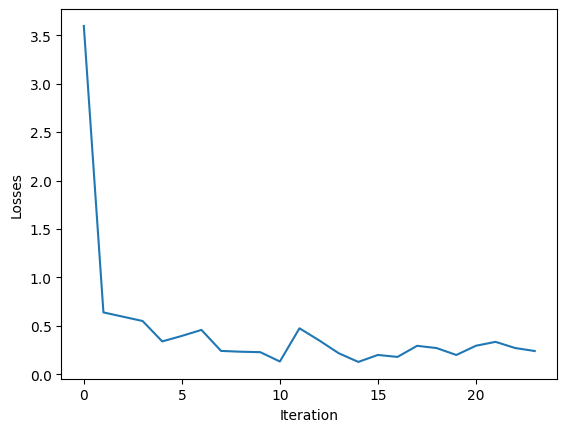

In [27]:
params = [p for p in model.parameters() if p.requires_grad]
# The list comprehension iterates over all the parameters in the model 
# and selects only those that have requires_grad set to True. 
# These are the parameters that will be updated during the training process.
optimizer = torch.optim.SGD(params, 
                            lr=LEARNING_RATE, 
                            momentum=MOMENTUM, 
                            weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                               step_size=STEP_SIZE, 
                                               gamma=GAMMA) 

import time
start_time = time.time()
losses = []
NUM_TRAIN = len(data_loader_train)
for epoch in range(EPOCH):
    model.train()  # train model
    for i, (image, target) in enumerate(data_loader_train):
        image = list(image.to(DEVICE) for image in image) # The model can process both a single image and a list (or batch) of images. 
        target = [{k: v.to(DEVICE) for k, v in t.items()} for t in target] # Target is a list with dictionary as an element

        loss_dic = model(image, target) # The model returned scores, bbox_deltas
        loss = sum(loss for loss in loss_dic.values())  # Calculate the sum of errors

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i%100 == 0:  # Progress is displayed every 100 times
            print(f"Epoch:, {epoch+1:02d}/{EPOCH:02d}",  
                  f"| Batch: {i:03d}/{NUM_TRAIN:03d}",  
                  f"| Loss:, {loss.item():.4f}") 
            losses.append(loss.item())
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    # Update the learning rate
    lr_scheduler.step()
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')

plt.plot(losses)
plt.ylabel('Losses')
plt.xlabel('Iteration')
plt.show()

In [28]:
all_preds_train,all_targets_train = get_evadata(data_loader_train)
precision_train, recall_train, f1_train, eva_preds_train = evaluate_model(model, all_preds_train,all_targets_train)
print(f'TRAIN\nPrecision: {precision_train:0.4f}\nRecall: {recall_train:0.4f}\nF1 Score: {f1_train:0.4f}')
metric_train = MeanAveragePrecision()
metric_train.update(eva_preds_train, all_targets_train)
from pprint import pprint
pprint(metric_train.compute())

all_preds_test,all_targets_test = get_evadata(data_loader_test)
precision_test, recall_test, f1_test, eva_preds_test = evaluate_model(model, all_preds_test, all_targets_test)
print(f'\nTEST\nPrecision: {precision_test:0.4f}\nRecall: {recall_test:0.4f}\nF1 Score: {f1_test:0.4f}')
metric_test = MeanAveragePrecision()
metric_test.update(eva_preds_test, all_targets_test)
pprint(metric_test.compute())

TRAIN
Precision: 0.6640
Recall: 0.9587
F1 Score: 0.7846
{'map': tensor(0.5301),
 'map_50': tensor(0.7961),
 'map_75': tensor(0.6116),
 'map_large': tensor(0.5628),
 'map_medium': tensor(0.4901),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.2946),
 'mar_1': tensor(0.4257),
 'mar_10': tensor(0.6139),
 'mar_100': tensor(0.6196),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.6550),
 'mar_medium': tensor(0.5781),
 'mar_small': tensor(0.3675)}

TEST
Precision: 0.6168
Recall: 0.9242
F1 Score: 0.7398
{'map': tensor(0.4344),
 'map_50': tensor(0.6860),
 'map_75': tensor(0.4794),
 'map_large': tensor(0.4880),
 'map_medium': tensor(0.3357),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.1534),
 'mar_1': tensor(0.3757),
 'mar_10': tensor(0.5296),
 'mar_100': tensor(0.5331),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.5892),
 'mar_medium': tensor(0.4428),
 'mar_small': tensor(0.2234)}


## Using Trained Models
### Predict on one image

The trained model is used to make predictions.
At this point we do not consider the target score, so you will see a large number of bounding boxes and labels.

In [ ]:

dataiter = iter(data_loader_test)  # iterator
image, target = next(dataiter)  # retrieve a batch

image = list(image.to(DEVICE) for image in image)

model.eval()
predictions = model(image)

image = (image[0]*255).to(torch.uint8).cpu() 
# print(predictions)

# image = (image[0]*255).to(torch.uint8).cpu() 
# boxes = predictions[0]["boxes"].cpu()
# labels = predictions[0]["labels"].cpu().detach().numpy()
# labels = np.where(labels>=len(index2name), 0, labels)  # 0 if the label is out of range.
# names = [index2name[label.item()] for label in labels]

# print(names)
# show_boxes(image, boxes, names)


### Prediction result
Filter the boxes with scores above 0.5.


In [ ]:

boxes = []
names = []

# print(predictions)
# print(list(target))

(pred_boxes, pred_labels, pred_scores),(gt_boxes,gt_labels)=transform_eva(predictions[0],list(target)[0])

if max(pred_scores)<=0.5:
    max_idx = np.argmax(np.array(pred_scores))

    box = pred_boxes[max_idx]
    boxes.append(list(box))
    label = pred_labels[max_idx]
    names.append(index2name[label])
else:
    for i, box in enumerate(pred_boxes):
        score = pred_scores[i]
        box = pred_boxes[i]
        label = pred_labels[i]
        if score > 0.5:  # Extract scores greater than 0.5
            if label >= len(index2name):  # 0 if the label is out of range.
                label = 0
            name = index2name[label]
            names.append(name)
            boxes.append(box)

boxes = torch.tensor(boxes)

show_boxes(image, boxes, names)

### Coresponding ground true.


In [ ]:
# gt_names=[]
# for lable in gt_labels:
#     gt_names.append(index2name[label])
# show_boxes(image,torch.tensor(list(gt_boxes)),gt_names)